In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def set_plot_params(title, ylabel):
    plt.title(title)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks(rotation=30, fontsize=12)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30))


def calculate_ylim(data):
    ylim_min = min(data) - (max(data) - min(data)) * 0.1
    ylim_max = max(data) + (max(data) - min(data)) * 0.1
    return ylim_min, ylim_max


def draw_graph(data: pd.DataFrame, title: str, ylabel: str, date_lst: list, color="blue"):
    '''
    :param data: 시간 인덱스와 그래프로 표시할 정보가 있는 데이터프레임
    :param title: 그래프 제목
    :param ylabel: 그래프 y축 단위
    :param date_lst: 아웃라이어 날짜인덱스 리스트
    :param color: 그래프 색깔
    :return: 
    '''
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data.values, color=color)
    for date in date_lst:
        plt.axvline(pd.to_datetime(date), color='red', linestyle='--', label='Highlight Date')
    set_plot_params(title, ylabel)
    ylim_min, ylim_max = calculate_ylim(list(data.values))
    plt.ylim(ylim_min, ylim_max)
    plt.show()

In [4]:
def compute_CUSUM(X):
    N = len(X)
    CUSUM = np.zeros(N + 1)
    for k in range(1, N + 1):
        CUSUM[k] = CUSUM[k - 1] + X[k - 1] ** 2
    return CUSUM


def compute_gamma(X, T, m, C):
    gamma = np.zeros(m + 1)
    mean_X = np.mean(X)
    r = X - mean_X  # 잔차 계산
    r_squared = X ** 2
    # sigma_squared = np.mean(r_squared)
    # 1. 논문에 sigma square 정의가 Tth CUSUM/T 의미인가 싶어서 바꿨습니다.
    sigma_squared = C[-1] / T

    for i in range(1, m + 1):
        gamma_i = 0
        for t in range(i + 1, T):  # 2. i 부터 T로 되어 있었는데 논문은 i+1부터 T라 바꿨습니다.
            gamma_i += (r_squared[t] - sigma_squared) * (r_squared[t - i] - sigma_squared)
        gamma[i] = gamma_i / T
    return gamma


def compute_lambda(gamma, m):
    lambda_hat = gamma[0] + 2 * sum((1 - i / (m + 1)) * gamma[i] for i in range(1, m + 1))
    # lambda_hat = np.abs(lambda_hat)
    return lambda_hat


def compute_D_prime(CUSUM, T, lambda_hat):
    D_prime = np.zeros(T)
    for k in range(1, T + 1):
        D_prime[k - 1] = (CUSUM[k] - (k / T) * CUSUM[T]) / np.sqrt(lambda_hat)
    return D_prime


def compute_t_star(D_prime, T):
    D_prime_abs = np.abs(D_prime) * np.sqrt(T / 2)
    t_star = np.argmax(D_prime_abs) + 1  # 인덱스는 0부터 시작하므로 +1

    # 3. 논문이 95%보다 큰 값을 다 t_star로 잡은 것으로 이해했습니다. 그러나 좀 보수적으로 하기 위해 99%보다 큰 값을 t_star로 했습니다.
    # 표준화하여 z-스코어 계산
    mean_D_prime_abs = np.mean(D_prime_abs)
    std_D_prime_abs = np.std(D_prime_abs)
    Z = (D_prime_abs - mean_D_prime_abs) / std_D_prime_abs

    # 2.58 표준편차 초과하는 값 찾기
    # threshold = 1.5
    # change_points = np.where(Z > threshold)[0] + 1
    critical_value = np.percentile(D_prime_abs, 99)  # 1% significance level
    change_points = np.where(np.abs(D_prime_abs) > critical_value)[0] + 1
    return list(change_points)

In [5]:
N = 1000
T = N
np.random.seed(0)
X = np.random.normal(0, 1, N)
jump_magnitude = 20
jump_position = N // 2
X[jump_position:] += jump_magnitude

# Neway-West 통계량의 최대시차
m = round(T**(1/4))

In [6]:
# CUSUM 계산
CUSUM = compute_CUSUM(X)

# gamma 계산
gamma = compute_gamma(X, T, m, CUSUM)

# lambda_hat 계산
lambda_hat = compute_lambda(gamma, m)

In [7]:
# D_prime 계산
D_prime = compute_D_prime(CUSUM, T, lambda_hat)

In [8]:
t_star = compute_t_star(D_prime, T)

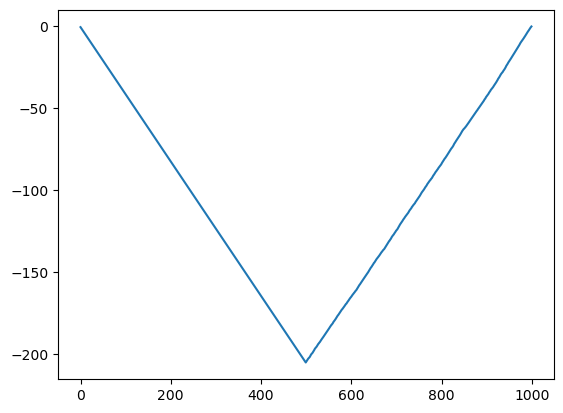

In [9]:
plt.plot(D_prime)

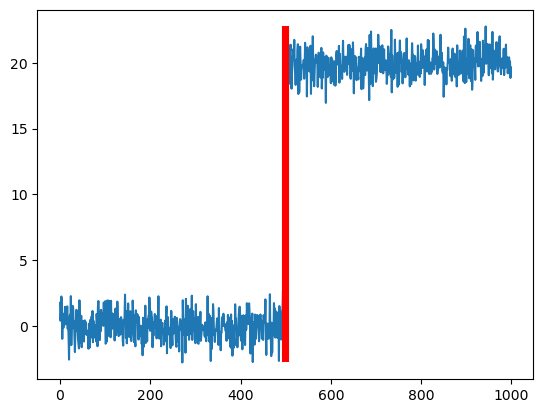

In [10]:
plt.plot(X)
plt.vlines(t_star, min(X), max(X), 'r')

In [11]:
info_wo_tle_df = pd.read_csv('File/info_wo_tle_df.csv', index_col=0)
name = 'perigee'
df = info_wo_tle_df[['year', 'month', 'day', 'hour', name]]

In [12]:
df_1 = df.copy()
df_1.loc[:, 'datetime'] = pd.to_datetime(df_1[['year', 'month', 'day', 'hour']])
df_1.set_index('datetime', inplace=True)
df_1.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)
df_1 = df_1.resample('h').mean()

In [13]:
df_2 = df_1.diff().dropna().values

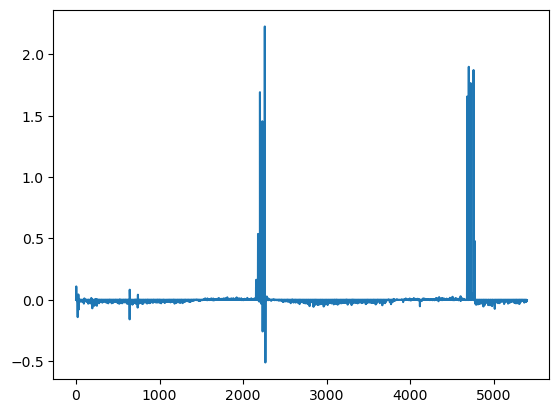

In [14]:
plt.plot(df_2)

In [15]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_2)
print('ADF')
print(f'Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical values: {result[4]}')
print('---' * 40)

result = kpss(df_2)
print('KPSS')
print(f'Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical values: {result[3]}')
print('---' * 40)

ADF
Statistics: -6.803794134222781
p-value: 2.2028338486368704e-09
Critical values: {'1%': -3.4315692379749074, '5%': -2.862078779432107, '10%': -2.56705679155445}
------------------------------------------------------------------------------------------------------------------------
KPSS
Statistics: 0.5200638379748717
p-value: 0.037147784239893775
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
------------------------------------------------------------------------------------------------------------------------


In [16]:
ol_points = []
diff_lst = []
t_lst = []
D_lst = []
minus = 0
for i in tqdm(range(len(df_2))):
    if i < 1000:
        continue
    X = df_2[i - 1000:i]
    T = len(X)

    # CUSUM 계산
    CUSUM = compute_CUSUM(X)

    # gamma 계산
    gamma = compute_gamma(X, T, m, CUSUM)

    # lambda_hat 계산
    lambda_hat = compute_lambda(gamma, m)
    if lambda_hat < 0:
        minus += 1

    # D_prime 계산
    D_prime = compute_D_prime(CUSUM, T, lambda_hat)
    t_star = compute_t_star(D_prime, T)
    t_lst.append(t_star)
    D_lst.append(np.mean(D_prime))
    # diff_lst.append(len(X) - t_star)

    if (len(X) - 1) in t_star:
        ol_points.append(i)

 29%|██▊       | 1546/5399 [00:20<01:02, 61.82it/s]  C:\Users\asas4\AppData\Local\Temp\ipykernel_7296\3137334423.py:35: RuntimeWarning: invalid value encountered in sqrt
  D_prime[k - 1] = (CUSUM[k] - (k / T) * CUSUM[T]) / np.sqrt(lambda_hat)
100%|██████████| 5399/5399 [03:15<00:00, 27.57it/s]


In [17]:
minus

1394

Text(0.5, 1.0, 'D_Prime')

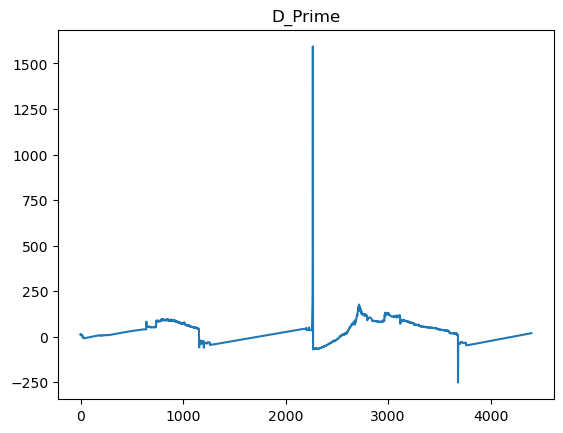

In [38]:
# m값 바꿔도 안사라지는 음수값들 때문에 중간에 D_prime nan값 생깁니다.
plt.plot(np.array(D_lst))
plt.title('D_Prime')

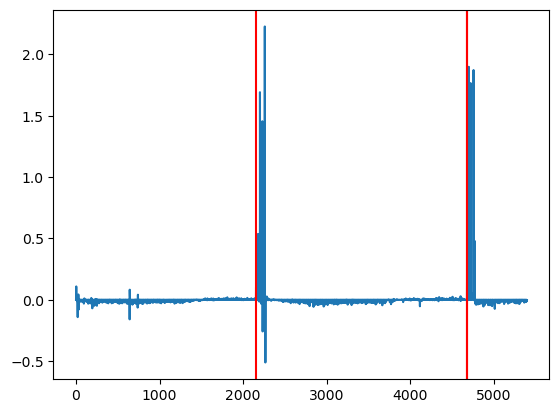

In [39]:
plt.plot(df_2)
for ol_point in ol_points:
    plt.axvline(ol_point, color='r')

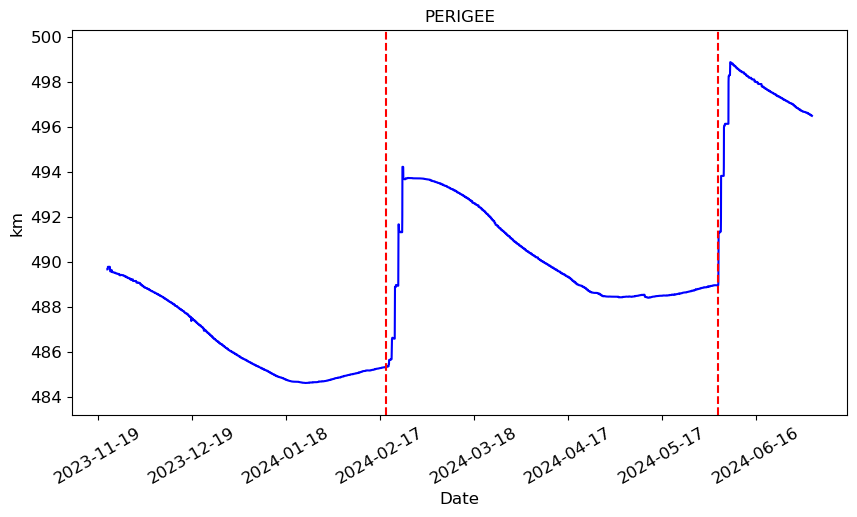

In [40]:
draw_graph(df_1, name.upper(), 'km',
           pd.DataFrame(df_1.iloc[ol_points].index.date).drop_duplicates().values.tolist(), "blue")